# mdx VMのデプロイとVCP既存サーバ (SSH) モード セットアップ

この Notebook では、mdx VM のデプロイと、その mdx VM をVCP既存サーバ(SSH) モードで利用できるようにするまでのセットアップを行います。

VCPで利用可能なクラウド環境にはAWSのようなパブリッククラウドや、学術機関のクラウド、オンプレミスシステム向けなど複数あります。  
mdx VM (仮想マシン) をこれらのクラウドの計算資源と同じようにVCPで扱うためには、いくつかの事前準備が必要となります。

具体的には、Terraform Provider Pluginに非対応の環境でもVCPを利用可能とするために、既存のVMやベアメタルサーバに対してVCコントローラからSSHでVC Nodeをデプロイ可能な環境を準備します。

VCPにおけるmdxサポートに関する経緯・背景等については、以下の資料を参照してください。

* NIIオープンフォーラム2022 / クラウドトラック2 / 学認クラウドオンデマンド構築サービス・SINETStream  
  [VCP (Virtual Cloud Provider) の mdx サポートに向けた実装と活用例 (pdf)](https://www.nii.ac.jp/openforum/upload/20220601PM_Cloud2_02.pdf)

## 前提条件

1. VCコントローラが動作していること
    * サービス版のVCコントローラ、またはVCPポータブル版のVCコントローラを使用
2. `vcp_config/vcp_config.yml` ファイルにおいてVCコントローラへの接続設定が完了していること

## 準備

1. mdx REST API 認証トークン設定
2. mdx VM にSSHログインするためのキーペア作成
3. mdx の REST API エンドポイントに接続できることの確認

### mdx REST API 認証トークン設定

mdx REST API 認証トークンは、[mdxユーザポータル](https://oprpl.mdx.jp/) の「トークン発行」により取得します。
> 「トークン発行」は、ユーザポータル画面右上にあるユーザ名をクリックすると表示できます。
  
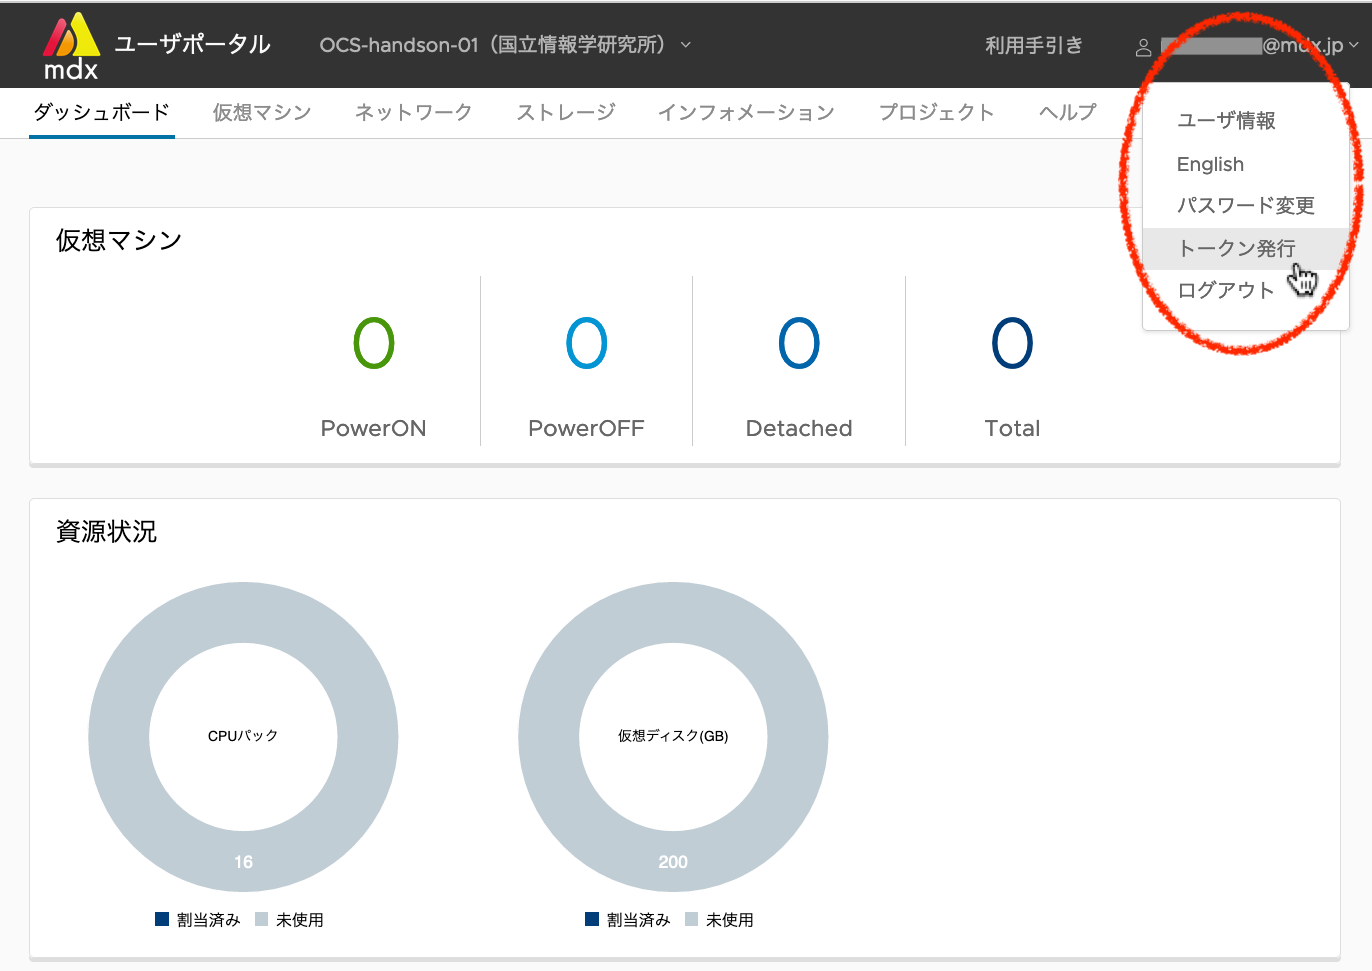

以下のセルを実行してmdx REST API認証トークンを入力します。

In [ ]:
from getpass import getpass
mdx_token = getpass("mdx API token")

### mdx VM への SSH ログイン用キーペア作成

mdx VM デプロイ時の設定項目に含まれる公開鍵を用意します。

In [ ]:
!test -f ~/.ssh/id_rsa || ssh-keygen -t rsa -f ~/.ssh/id_rsa -N ""
!ls -l ~/.ssh

### mdx REST API エンドポイント接続確認

mdx REST APIエンドポイントにIPv6で接続しようとすると到達不可となる場合があるため、以下のセルを実行してIPv4での接続を強制します。

In [ ]:
# デフォルトのresolverがIPv6のアドレスを返すことにより以降のAPIで接続不可の場合があるため、以下のコードを実行しておく。
def use_ipv4_only():
    import socket
    old_getaddrinfo = socket.getaddrinfo
    def new_getaddrinfo(*args, **kwargs):
        responses = old_getaddrinfo(*args, **kwargs)
        return [response
                for response in responses
                if response[0] == socket.AF_INET]
    socket.getaddrinfo = new_getaddrinfo

use_ipv4_only()

以下のセルを実行し、HTTPステータスコード 200 が返ることを確認します。

In [ ]:
!curl https://oprpl.mdx.jp -w '%{http_code}\n' -o /dev/null -s

## mdx VM 作成

1. VCP SDK mdx用プラグインモジュールの読み込み
2. mdx VM作成に必要なパラメータ設定
3. mdx VMデプロイ実行

### VCP SDK mdx用プラグインモジュールの読み込み

In [ ]:
from common import logsetting
from vcpsdk.plugins.mdx_ext import MdxResourceExt
mdx = MdxResourceExt(mdx_token)

### mdx VM作成に必要なパラメータ設定

- プロジェクトID
- ネットワークセグメントID
- sshログインのための公開鍵

自身が所属している（利用可能な）mdxのプロジェクト情報を確認します。

In [ ]:
import json
projects = mdx.get_assigned_projects()
for org in projects:
    print(json.dumps(org["projects"], indent=2, ensure_ascii=False))

以降のmdx操作対象とする「プロジェクト名」 (`name`) を設定します。

In [ ]:
project_name = 'OCS-Developer2'
mdx.set_current_project_by_name(project_name)

操作対象として設定したプロジェクト情報を確認します。

In [ ]:
print(json.dumps(mdx.get_current_project(), indent=2))

プロジェクトで利用可能なットワークセグメントのリストを取得し、先頭のIDを設定します。

In [ ]:
segments = mdx.get_segments()
print(json.dumps(segments, indent=2))

segment_id = mdx.get_segments()[0]["uuid"]
print(segment_id)

sshログインのための公開鍵ファイルの内容を設定します。

In [ ]:
import os
with open(os.path.expanduser('~/.ssh/id_rsa.pub')) as f:
    ssh_shared_key = f.read()
print(ssh_shared_key)

### mdx VMデプロイ

ここでは、仮想マシンテンプレートとして「推奨版、東京大学制作、20220412-2043版」を使用します。
> 利用可能な仮想マシンテンプレートの一覧は、 `get_vm_catalogs()` により取得可能

ここでは、一例として、[ハードウェアのカスタマイズ項目](https://docs.mdx.jp/ja/main/create_vm.html#deploy-settings)を以下の内容で設定します。  
各項目の意味は前述のリンク先（ハードウェアのカスタマイズ項目）の説明を確認してください。
  * 仮想マシン名: `"vcp-host0001"` **（プロジェクト内で重複しないこと）**
  * パックタイプ: `"cpu"`
  * パック数: `3`
  * 仮想ディスク(GB): `40`
  * ストレージネットワーク: `"portgroup"`
  * サービスレベル: `"spot"`

mdx VMにIPアドレスが設定されるまで5分程度要するため、実行中のセルの経過時間を表示するライブラリ [jupyter-autotime](https://pypi.org/project/jupyter-autotime/) 機能を有効化します。

In [ ]:
!pip install jupyter-autotime
%load_ext autotime

VMのパラメータを設定します。

In [ ]:
DEFAULT_CATALOG = "16a41081-a1cf-428e-90d0-a147b3aa6fc2"
DEFAULT_TEMPLATE_NAME = "UT-20220412-2043-ubuntu-2004-server"

vm_name = "vcp-host0001"

mdx_spec = dict(
    catalog=DEFAULT_CATALOG,
    template_name=DEFAULT_TEMPLATE_NAME,
    pack_num=3,
    pack_type="cpu",
    disk_size=40,
    gpu="0",
    network_adapters=[
        dict(
            adapter_number=1,
            segment=segment_id
        )
    ],
    shared_key=ssh_shared_key,
    storage_network="portgroup",
)

2023-01-31のmdx REST APIの仕様変更により、VMのspecに `service_level` の指定が必須となりました。このため、 `service_level` を `spot` に指定して、明示的にスポットVMとしてデプロイするよう指定します。

In [ ]:
from vcpsdk.plugins.mdx_ext import MDX_VM_SPEC_SCHEMA

if not 'service_level' in MDX_VM_SPEC_SCHEMA['properties']:
    MDX_VM_SPEC_SCHEMA['properties'].update(
        {'service_level': {'type': 'string'}}
    )

mdx_spec.update({'service_level': 'spot'})

VMのデプロイを実行します。デプロイ完了後、VM情報を出力します。

In [ ]:
info = mdx.deploy_vm(vm_name, mdx_spec)
print(json.dumps(info, indent=2))

In [ ]:
# jupyter-autotime を無効化
%unload_ext autotime

VMに付与されたプライベートIPv4アドレス (先頭のアドレス) を取得します。

In [ ]:
host_ip_address = info["service_networks"][0]["ipv4_address"][0]
host_ip_address

## VCP既存サーバ (SSH) モード セットアップ

1. mdx VMへの疎通確認
2. VM初期パスワード設定
3. 既存サーバ(SSH) モード セットアップスクリプトをmdx VMへのコピー
4. 既存サーバ(SSH) モード セットアップ実行
5. Docker のインストール確認

### mdx VMへの疎通確認

In [ ]:
!ping -c 3 {host_ip_address}

### VM初期パスワード設定

* 仮想マシンテンプレート「推奨版、東京大学制作、20220412-2043版」では、初回ログイン時にはOSのパスワード設定が求められる
* ログインユーザ名は `mdxuser`

VMの初期パスワード（ここでは例として `mdx_vm_initial_password` を指定）をSSH経由で設定するために必要なパラメータを設定します。

In [ ]:
ssh_user_name = "mdxuser"
ssh_private_key_path = os.path.expanduser("~/.ssh/id_rsa")
mdx_user_password = "mdx_vm_initial_password"

expectスクリプトを用いてVMの初期パスワード設定を実行します。

In [ ]:
!./scripts/init_mdx_passwd.exp {ssh_user_name} {host_ip_address} {ssh_private_key_path} {mdx_user_password}

### 既存サーバ(SSH) モード セットアップスクリプトをmdx VMへのコピー

In [ ]:
# notebookからmdx VMへのsshコマンドオプション
ssh_opts = f" -i {ssh_private_key_path} -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null"

In [ ]:
!scp -i tmp/id_rsa -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null scripts/init_mdx_node.sh {ssh_user_name}@{host_ip_address}:

### 既存サーバ(SSH) モード セットアップ実行

- docker-ce インストール
- sshd_config 設定変更: Port 20022 

In [ ]:
!ssh {ssh_opts} {ssh_user_name}@{host_ip_address} ./init_mdx_node.sh

### Docker のインストール確認

In [ ]:
!ssh {ssh_opts} -p 20022 {ssh_user_name}@{host_ip_address} sudo docker ps

## VCコントローラ公開鍵設定

VCコントローラがmdx VMを既存サーバ(SSH) モードで制御するにはSSH接続を使用します。そのため、VCコントローラのSSH公開鍵をmdx VMに登録しておく必要があります。

1. VCP SDKの初期化
2. VCコントローラ公開鍵設定

### VCP SDKの初期化

VCP SDKを利用するにはVCコントローラのアクセストークンが必要となります。次のセルを実行すると入力枠が表示されるのでアクセストークンの値を入力してください。

> アクセストークン入力後に Enter キーを押すことで入力が完了します。

In [ ]:
# VCP REST API アクセストークンの入力
from getpass import getpass
vcc_access_token = getpass()

In [ ]:
# VCP SDK 初期化
from vcpsdk.vcpsdk import VcpSDK
sdk = VcpSDK(vcc_access_token)

### VCコントローラ公開鍵取得設定

VCP SDK の「VCコントローラ公開鍵取得」APIを使って公開鍵を取得し、それをmdx VMにコピーします。

In [ ]:
# VCコントローラが既存サーバを操作するときに使うssh公開鍵を取得する
vcc_ssh_pubkey = sdk.get_publickey()
print(vcc_ssh_pubkey)

In [ ]:
# 公開鍵をmdx VMにコピーする
!echo "{vcc_ssh_pubkey}" | (ssh {ssh_opts} -p20022 {ssh_user_name}@{host_ip_address} "cat >> ~/.ssh/authorized_keys")

## まとめ

ここまでで、mdx VMに対してVCコントローラからSSHでVC Nodeをデプロイ可能な環境の準備が整いました。

VCノード作成時のパラメータ設定は、以下の点に注意してください。

* クラウドプロバイダ名は `"onpremises"` を指定
* `ip_addresses`: Baseコンテナを起動するホスト (mdx VM) のIPアドレス
* `user_name`: Baseコンテナを起動するホスト (mdx VM) 上のsudo可能なアカウント名 (e.g. `mdxuser`)
* `set_ssh_pubkey`: BaseコンテナへのSSHログイン用公開鍵ファイルのパス